In [1]:
!pip install pyyaml h5py  # Required to save models in HDF5 format
!git clone https://github.com/Mahsarnzh/XAI_Nuc.git

Cloning into 'XAI_Nuc'...
remote: Enumerating objects: 194, done.
remote: Counting objects: 100% (115/115), done.
remote: Compressing objects: 100% (71/71), done.
remote: Total 194 (delta 49), reused 103 (delta 44), pack-reused 79
Receiving objects: 100% (194/194), 13.83 MiB | 11.27 MiB/s, done.
Resolving deltas: 100% (78/78), done.


In [2]:
!pip install shap

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 547.9/547.9 kB 4.7 MB/s eta 0:00:00


In [3]:
import sys
import os
sys.path.append("/content/XAI_Nuc/")

In [4]:
import shap

Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)


In [5]:
%cd /content/XAI_Nuc

/content/XAI_Nuc


In [6]:
import criticNet.model
import actorNet.model

In [7]:
import criticNet_env.model
import actorNet_env.model

In [8]:
model_actorNet = actorNet.load_model(os.path.join(os.path.dirname(actorNet.__file__), "weights.h5"))
model_criticNet = criticNet.load_model(os.path.join(os.path.dirname(criticNet.__file__), "weights.h5"))

In [9]:
model_actorNet_env = actorNet_env.load_model(os.path.join(os.path.dirname(actorNet_env.__file__), "weights.h5"))
model_criticNet_env = criticNet_env.load_model(os.path.join(os.path.dirname(criticNet_env.__file__), "weights.h5"))

In [10]:
! pip install onnx_tf

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 226.1/226.1 kB 2.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.6/14.6 MB 46.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 612.1/612.1 kB 15.0 MB/s eta 0:00:00


In [11]:
import onnx

from onnx_tf.backend import prepare

actorNet_onnx_model = onnx.load("actorNet_Correct.onnx")  # load onnx model
tf_rep = prepare(actorNet_onnx_model)  # prepare tf representation
tf_rep.export_graph("output_path")



TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 



In [12]:
import tensorflow as tf
import numpy as np

# Load the ONNX model
actorNet_onnx = onnx.load("actorNet_Correct.onnx")

# Prepare the ONNX model for TensorFlow
actorNet_onnx_model = prepare(actorNet_onnx)

In [13]:
!pip install onnxruntime

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.2/6.2 MB 25.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.0/46.0 kB 4.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 86.8/86.8 kB 9.6 MB/s eta 0:00:00


In [14]:
import numpy as np
import gym
from gym import spaces
import itertools
from gym.spaces import Box

class Nuc_Maint_Env_Proposal_220211_NPIC_MATLAB2022A(gym.Env):
    def __init__(self):
        self.NumComponents = 1
        self.MaxTime = 200
        self.RefuelPeriod = 18
        self.MaxInitialHealth = 0.9999
        self.MinInitialHealth = 0.8
        self.InitialHealthNoise = 0.01
        self.MinHealth = 0
        self.DegradationMean = 0.05
        self.DegradationVar = 0.1
        self.SensorNoiseVar = 0
        self.LeadTime = 5
        self.PenaltyForThirdCapacity = -40
        self.PenaltyForHalfCapacity = -60
        self.PenaltyForNotOperating = -100
        self.CostToRepair = -10
        self.CostToReplace = -5
        self.CostToOrder = -15
        self.CostInventory = -1

        self.ObservationInfo = spaces.Box(low=-np.inf, high=np.inf, shape=(5, 1), dtype=np.float32)

        elements = np.array([[0, 0], [1, 0], [2, 0], [0, 1], [1, 1], [2, 1]])

        ActionInfo = elements.tolist()
        self.ActionInfo = ActionInfo

        self.IsDone = 0

    def step(self, action):
        MaintDecision1 = action[0]
        OrderPart1 = action[1]

        Month = self.State[0]
        Component1 = self.State[1]
        Inv1 = self.State[2]
        ArrivalDate1 = self.State[3]
        PartReplaced1 = self.State[4]

        Month += 1
        PartReplaced1 = 0

        if MaintDecision1 == 2 and Inv1 > 0:  # Replace
            Inv1 -= 1
            Component1 = self.MaxInitialHealth - np.random.gamma(self.InitialHealthNoise)
            PartReplaced1 = 1

            if Component1 < self.MinInitialHealth:
                Component1 = self.MinInitialHealth

        elif MaintDecision1 == 1:  # Repair
            Component1 += (self.MaxInitialHealth - Component1) * 0.1  # about 10 percent increase in health gap



        if Month%(self.RefuelPeriod) != 0:
            Component1 -= np.abs(self.DegradationMean + self.DegradationVar * np.random.randn()) * (1 - Component1)


        if Component1 == 0:
            Sensor1 = 0  # self-announcing failure
        else:
            Sensor1 = Component1 + self.SensorNoiseVar * np.random.randn()
            if Sensor1 > 1:
              Sensor1 = min(Sensor1, 1)
            elif Sensor1 < 0:
              Sensor1 = max(Sensor1,0)
            Sensor1 = max(min(Sensor1, 1), 0)

        if Month % self.RefuelPeriod == 0:
            DaysToShutdown = 0
        else:
            DaysToShutdown = (self.RefuelPeriod - Month%(self.RefuelPeriod)) / self.RefuelPeriod


        ArrivalDate1 = [x - 1 for x in ArrivalDate1]

        if len(ArrivalDate1) > 0:
            if ArrivalDate1[0] == 0:
                Inv1 += 1  # Add part to inventory
                ArrivalDate1 = [x for x in ArrivalDate1 if x > 0]  # Remove countdown from backlog



        if OrderPart1:
            ArrivalDate1 = np.append(ArrivalDate1, self.LeadTime)

        if len(ArrivalDate1) > 0:
            OnOrder1 = ArrivalDate1[0] / self.LeadTime
        else:
            OnOrder1 = 0

        InvNorm1 = Inv1 / 200
        InvFlag1 = int(np.any(Inv1 > 0))

        self.State = np.array([Month, Component1, Inv1, ArrivalDate1, PartReplaced1] , dtype=object)

        observation = np.array([DaysToShutdown, Sensor1, InvNorm1, InvFlag1, OnOrder1])

        self.IsDone = 0
        reward = self.get_reward(self.State, action)
        return observation, reward, self.IsDone, {}

    def reset(self):
        Component1 = self.MaxInitialHealth - 0.05 * np.random.rand()
        Sensor1 = Component1 + self.SensorNoiseVar * np.random.randn()
        Sensor1 = max(min(Sensor1, 1), 0)
        Inv1 = 0
        InvNorm1 = Inv1 / 200
        InvFlag1 = int(Inv1 > 0)
        ArrivalDate1 = []
        OnOrder1 = 0
        PartReplaced1 = 0
        Month = 1

        if Month%(self.RefuelPeriod) == 0:
            DaysToShutdown = 0
        else:
            DaysToShutdown = (self.RefuelPeriod - (Month%self.RefuelPeriod)) / self.RefuelPeriod

        initial_observation = np.array([DaysToShutdown, Sensor1, InvNorm1, InvFlag1, OnOrder1])
        initial_observation = tf.ragged.constant(initial_observation)

        self.State = np.array([Month, Component1, Inv1, ArrivalDate1, PartReplaced1], dtype=object)

        return initial_observation

    def get_reward(self, State, Action):
        Month = State[0]
        Sensor1 = State[1]
        Inv1 = State[2]
        PartReplaced1 = State[4]

        Action1 = Action[0]
        OrderPart1 = Action[1]

        reward = 0

        if Inv1 > 0:
            reward += self.CostInventory * Inv1

        reward += self.CostToOrder * OrderPart1

        if Sensor1 == 0 and Month % self.RefuelPeriod != 0:
            reward += 2 * self.PenaltyForHalfCapacity
        elif PartReplaced1 and Month % self.RefuelPeriod != 0:
            reward += 2 * self.PenaltyForHalfCapacity

        if Action1 == 1:
            reward += self.CostToRepair
        elif PartReplaced1:
            reward += self.CostToReplace

        return reward


In [15]:
# import tensorflow as tf
import numpy as np
from matplotlib import pyplot as plt

env = Nuc_Maint_Env_Proposal_220211_NPIC_MATLAB2022A()

discount_factor = 0.999
max_steps_per_episode = 720

# Define the optimization algorithms for actor and critic networks
actor_optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
critic_optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)



actor = model_actorNet_env
critic = model_criticNet_env
state_tensors = []
episode_rewards = []
actionss = []
num_episodes = 1
for episode in range(num_episodes):
    state = env.reset()
    episode_reward = 0

    # with tf.GradientTape(persistent=True) as tape:
    for t in range(max_steps_per_episode):

        state_tensor = tf.convert_to_tensor(state)
        state_tensor_ = tf.expand_dims(state_tensor, 0)

        input_data = tf.cast(state_tensor_, dtype=tf.float32)
        # Create input tensor
        input_data = tf.constant(input_data, dtype=tf.float32)
        state_tensors.append(input_data)


        # Get action probabilities from actor network
        action_probs = actorNet_onnx_model.run(input_data)



        # Sample an action from the action probabilities
        action_log_prob = tf.argmax(action_probs, axis=-1)
        action_index = action_log_prob.numpy().item()

        # action_log_prob = torch.argmax(action_logits)
        actionelements = np.array([[0, 0], [1, 0], [2, 0], [0, 1], [1, 1], [2, 1]])


        # Retrieve the corresponding action

        action = actionelements[action_index]

        actionss.append(action)

        # Take the action in the environment
        state, reward, done, _ = env.step(action)

        episode_reward += reward
        episode_rewards.append(episode_reward)  # Save state_tensor to the list

        if done:
            break


    state_log_ = tf.squeeze(state_tensors)
    action_log_ = tf.squeeze(actionss)
    state_log_ = np.array(state_log_)
    action_log_ = np.array(action_log_)

    state_log = np.array(state_tensors)
    action_log = np.array(actionss)

    t_values = np.arange(num_episodes)  # Generate an array of indices from 0 to max_steps_per_episode


Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.


<Figure size 640x480 with 0 Axes>

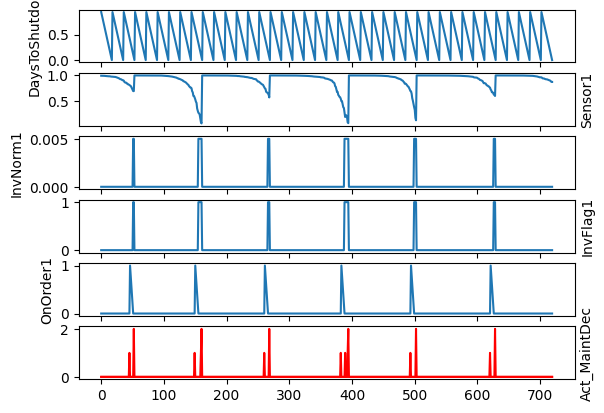

In [16]:
plt.figure()
axs = plt.subplots(sharex=True, sharey=False)

plt.subplot(611), plt.plot(state_log[:,0,0]), plt.ylabel('DaysToShutdown')

plt.subplot(612), plt.plot(state_log[:,0,1]), plt.ylabel('Sensor1')
plt.subplot(612).yaxis.set_label_position('right')

plt.subplot(613), plt.plot(state_log[:,0,2]), plt.ylabel('InvNorm1')

plt.subplot(614), plt.plot(state_log[:,0,3]), plt.ylabel('InvFlag1')
plt.subplot(614).yaxis.set_label_position('right')

plt.subplot(615), plt.plot(state_log[:,0,4]), plt.ylabel('OnOrder1')

plt.subplot(616), plt.plot(action_log, 'r'), plt.ylabel('Act_MaintDec')
plt.subplot(616).yaxis.set_label_position('right')

# plt.subplot(616), plt.plot(action_log[:,0], 'r'), plt.ylabel('Ac(0)_MaintDec')
# plt.subplot(616), plt.plot(action_log[:,1], 'r'), plt.ylabel('Act(1)_OrderPart')


In [17]:
def model_predict_Max(data):
    inputs = {actorNet_onnx_model.inputs[0]: data}
    outputs = actorNet_onnx_model.run(inputs)
    max_values = np.max(outputs[0], axis=-1)
    return max_values


In [18]:
# Define the names of the states
feature_names=['DaysToShutdown', 'Sensor1', 'InvNorm1', 'InvFlag1', 'OnOrder1']

In [19]:
def model_predict(data):
    inputs = {actorNet_onnx_model.inputs[0]: data}
    outputs = actorNet_onnx_model.run(inputs)

    return outputs[0]

# Max probable: Selected action

In [20]:
# state_log_reshaped = state_log.reshape(state_log.shape[0], -1)
# explainer__Max = shap.KernelExplainer(model_predict_Max, state_log_reshaped)
# shap_values__Max = explainer__Max.shap_values(state_log_reshaped)

In [21]:
state_log_reshaped = state_log.reshape(state_log.shape[0], -1)
explainer = shap.KernelExplainer(model_predict, state_log_reshaped)
shap_values = explainer.shap_values(state_log_reshaped)


  0%|          | 0/720 [00:00<?, ?it/s]

# MATLAB

No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


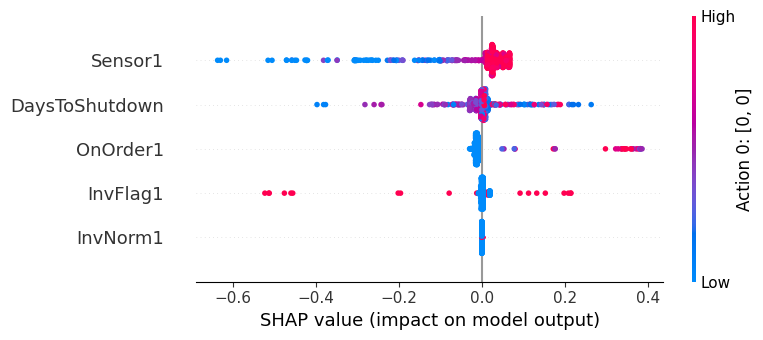

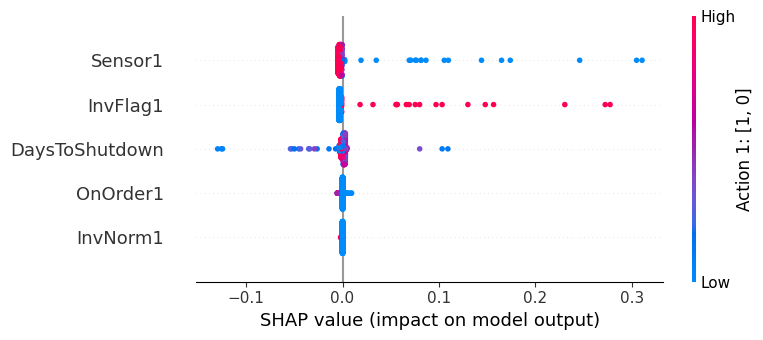

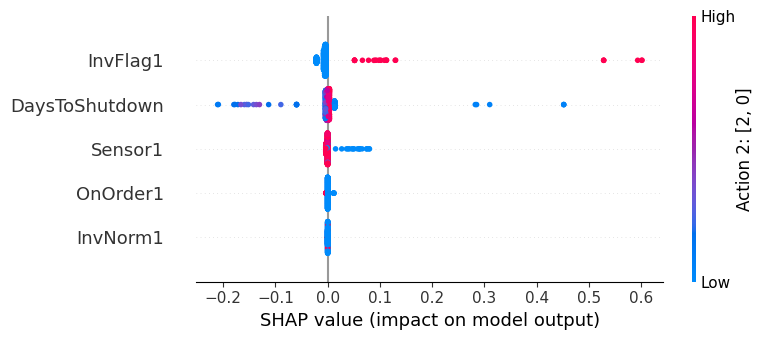

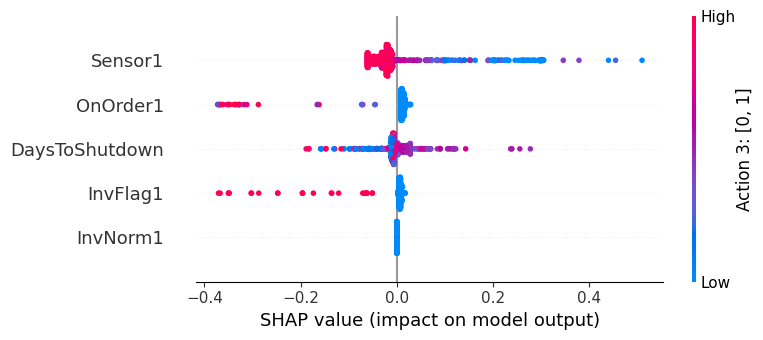

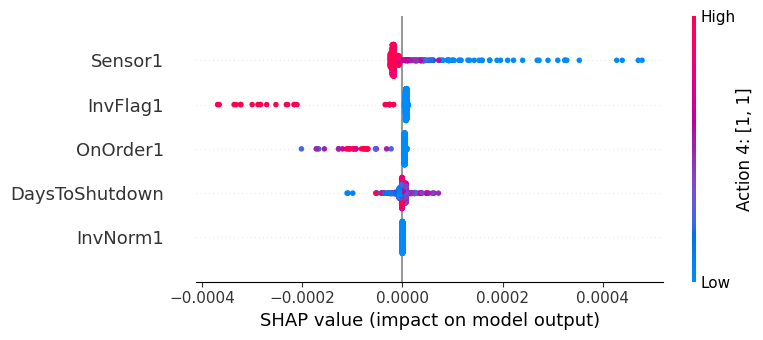

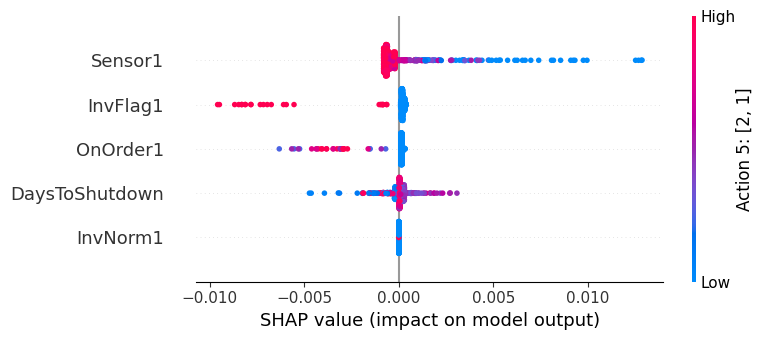

In [22]:
class_names = ["Action 0: [0, 0]", "Action 1: [1, 0]", "Action 2: [2, 0]", "Action 3: [0, 1]", "Action 4: [1, 1]", "Action 5: [2, 1]"]

shap_values_ = np.array(shap_values)
for i in range(shap_values_.shape[0]):
  shap.summary_plot(shap_values[i], state_log_reshaped, feature_names=feature_names, color_bar_label='{}'.format(class_names[i]))



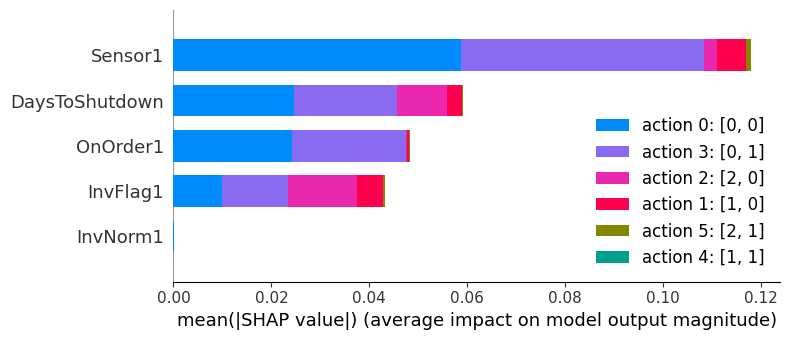

In [23]:
class_names = ["action 0: [0, 0]", "action 1: [1, 0]", "action 2: [2, 0]", "action 3: [0, 1]", "action 4: [1, 1]", "action 5: [2, 1]"]
shap.summary_plot(shap_values, feature_names=feature_names, class_names=class_names)


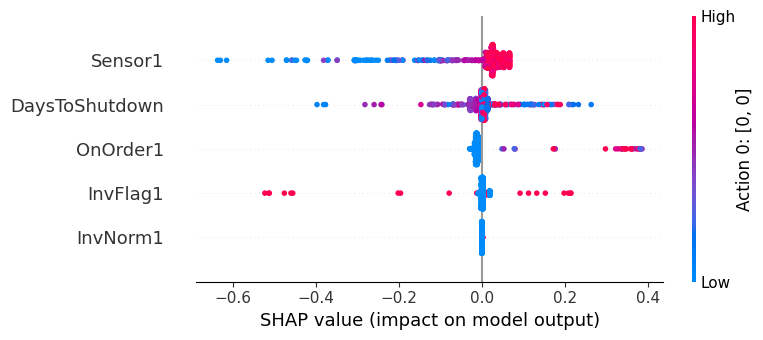

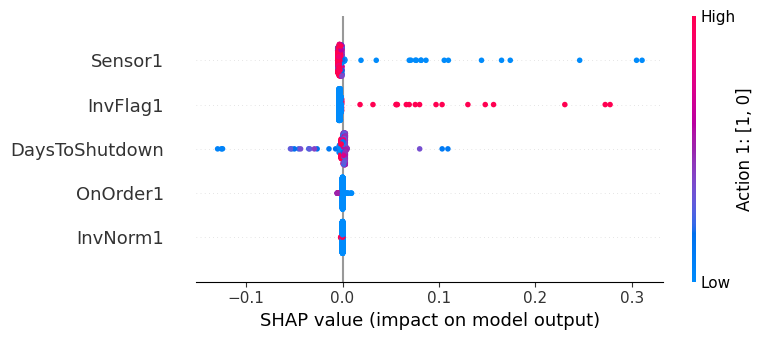

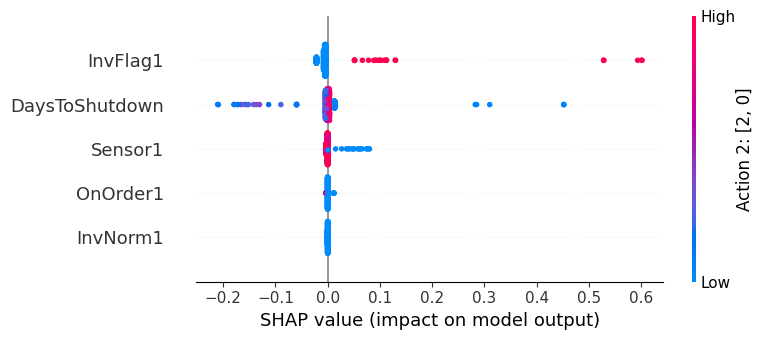

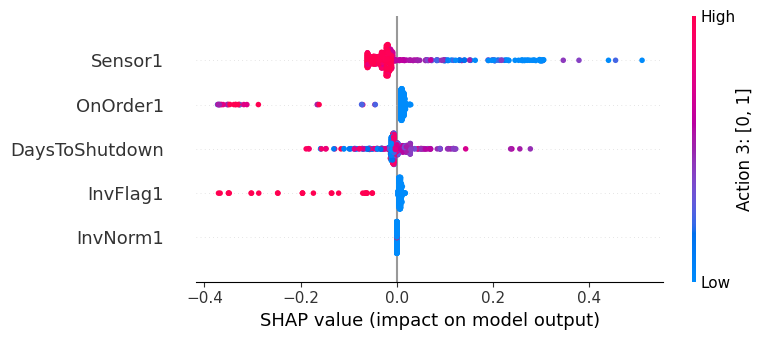

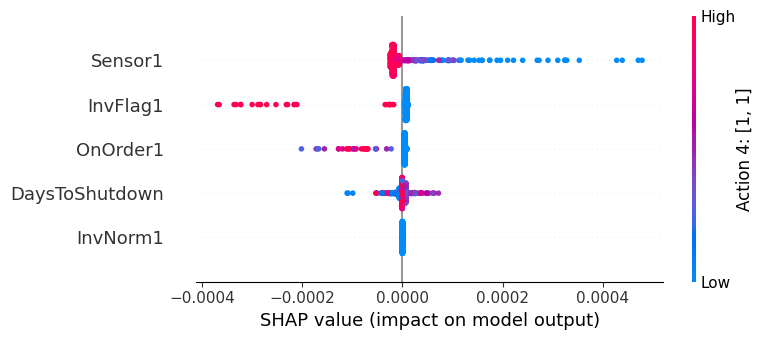

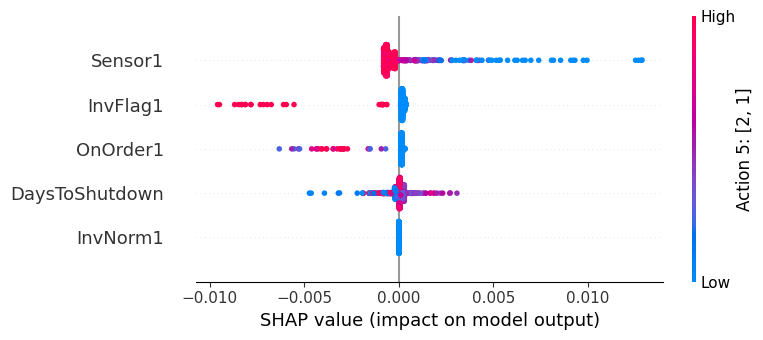

In [24]:
class_names = ["Action 0: [0, 0]", "Action 1: [1, 0]", "Action 2: [2, 0]", "Action 3: [0, 1]", "Action 4: [1, 1]", "Action 5: [2, 1]"]

shap_values_ = np.array(shap_values)
for i in range(shap_values_.shape[0]):
  shap.summary_plot(shap_values[i], state_log_reshaped,  feature_names=feature_names, color_bar_label='{}'.format(class_names[i]))



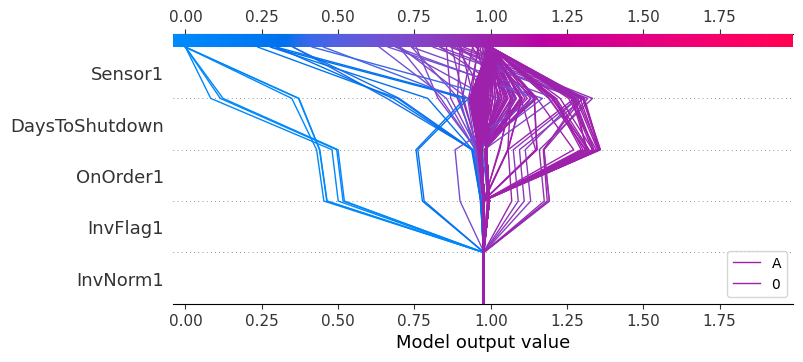

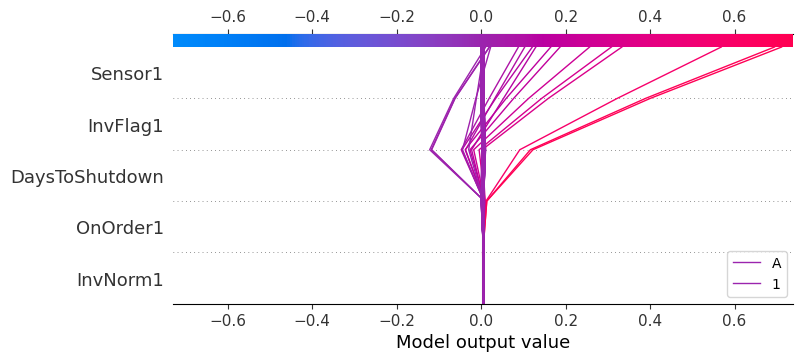

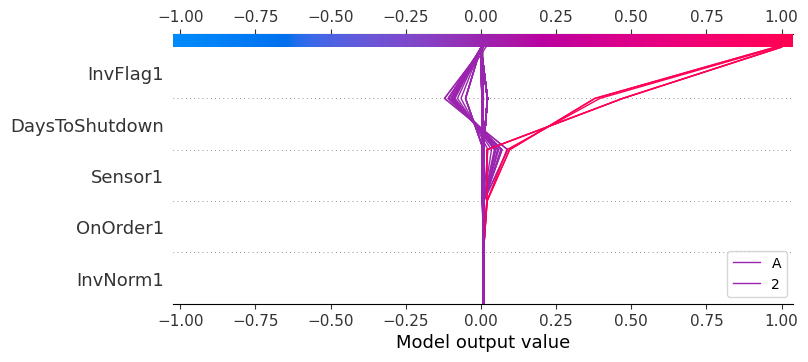

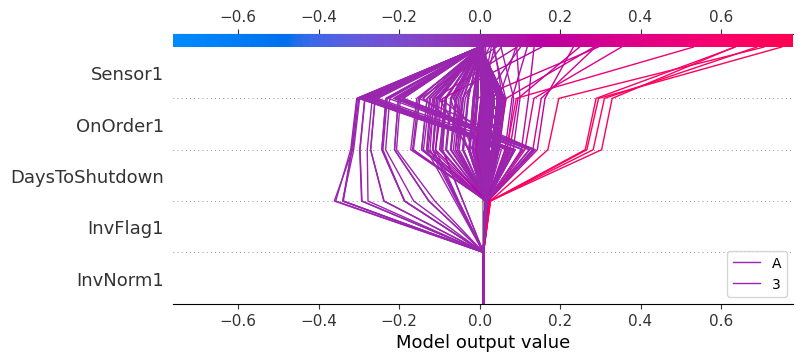

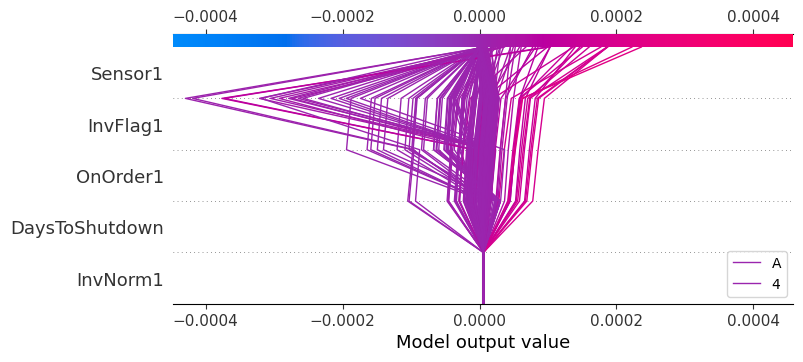

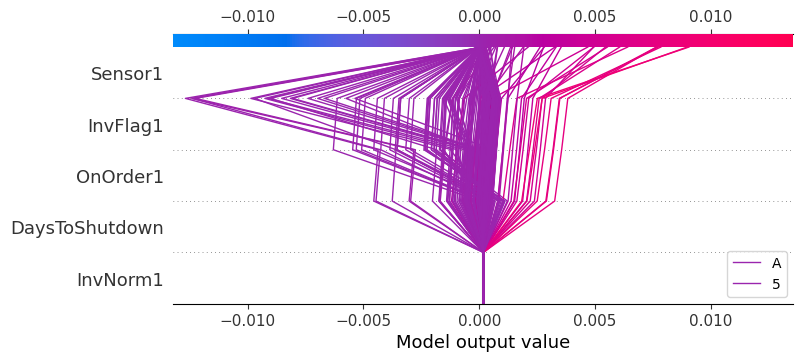

In [25]:
# class_names = ["Action 0: [0, 0]", "Action 1: [1, 0]", "Action 2: [2, 0]", "Action 3: [0, 1]", "Action 4: [1, 1]", "Action 5: [2, 1]"]
# class_names = ["Action 0", "Action 1", "Action 2", "Action 3", "Action 4", "Action 5"]
class_names = ["A0", "A1", "A2", "A3", "A4", "A5"]

for i in range(len(shap_values)):
  shap.decision_plot(explainer.expected_value[i], shap_values[i], feature_names=feature_names, legend_labels=class_names[i], legend_location='lower right')


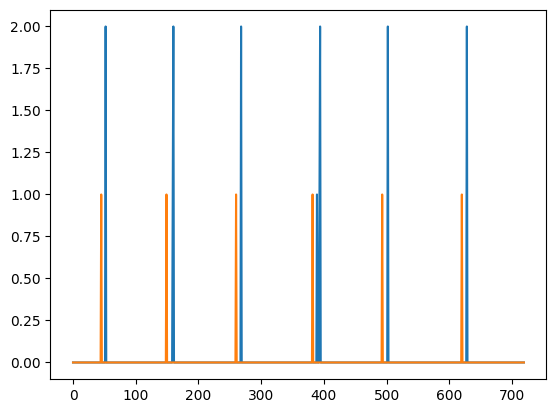

In [26]:
plt.plot(action_log)


Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.


(<Axes: ylabel='Observations'>,
 Text(0, 0.5, 'Observations'))

<Figure size 640x480 with 0 Axes>

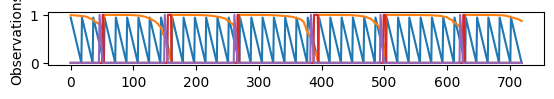

In [27]:
plt.figure()
axs = plt.subplots(sharex=True, sharey=False)

plt.subplot(611), plt.plot(state_log[:,0]), plt.ylabel('Observations')

In [28]:
shap.initjs()
shap.force_plot(explainer.expected_value[0], shap_values[0][0], feature_names=feature_names,
                link='logit', matplotlib=False)

In [29]:
shap.initjs()
shap.force_plot(explainer.expected_value[1], shap_values[1][0], feature_names=feature_names,
                link='logit', matplotlib=False)

In [30]:
shap.initjs()
shap.force_plot(explainer.expected_value[2], shap_values[2][0], feature_names=feature_names,
                link='logit', matplotlib=False)

In [31]:
shap.initjs()
shap.force_plot(explainer.expected_value[3], shap_values[3][0], feature_names=feature_names,
                link='logit', matplotlib=False)

In [32]:
shap.initjs()
shap.force_plot(explainer.expected_value[4], shap_values[3][0], feature_names=feature_names,
                link='logit', matplotlib=False)

## Make the function in a way that only gives 2 outputs of actions based on the observations and feed the shap plot with the MATLAB'S observation and action logs

In [33]:
def explain(state_log_=state_log_reshaped, feature_names=feature_names, action_log_=model_predict(state_log_reshaped), cmap='coolwarm', save_fig=False):


    state_log_reshaped_min = state_log_reshaped.min()
    state_log_reshaped_max = state_log_reshaped.max()

    state_log_re = state_log_*(state_log_reshaped_max - state_log_reshaped_min) + state_log_reshaped_min # rescale state log
    action_log = action_log_
    norm = plt.Normalize(vmin=-0.001, vmax=0.001) # define color scala between 0 and +2 (like the agents action space)

    fig = plt.figure(figsize=(15,12))
    gs = fig.add_gridspec(6, hspace=0)
    axs = gs.subplots(sharex=True, sharey=False)
    axs[0].scatter(range(0, action_log.shape[0]), action_log[:,0], c=action_log[:,0]- explainer.expected_value[0], cmap = cmap, norm=norm)
    axs[0].set_ylabel('action_probability')
    axs[0].yaxis.set_label_position('right')
    axs[0].scatter(range(0, action_log.shape[0]), action_log[:,1], c=action_log[:,1]- explainer.expected_value[1], cmap = cmap, norm=norm)
    axs[0].set_ylabel('action_probability')
    axs[0].yaxis.set_label_position('right')
    axs[0].scatter(range(0, action_log.shape[0]), action_log[:,2], c=action_log[:,2]- explainer.expected_value[2], cmap = cmap, norm=norm)
    axs[0].set_ylabel('action_probability')
    axs[0].yaxis.set_label_position('right')
    axs[0].scatter(range(0, action_log.shape[0]), action_log[:,3], c=action_log[:,3]- explainer.expected_value[3], cmap = cmap, norm=norm)
    axs[0].set_ylabel('action_probability')
    axs[0].yaxis.set_label_position('right')
    axs[0].scatter(range(0, action_log.shape[0]), action_log[:,4], c=action_log[:,4]- explainer.expected_value[4], cmap = cmap, norm=norm)
    axs[0].set_ylabel('action_probability')
    axs[0].yaxis.set_label_position('right')
    axs[0].scatter(range(0, action_log.shape[0]), action_log[:,5], c=action_log[:,5]- explainer.expected_value[5], cmap = cmap, norm=norm)
    axs[0].set_ylabel('action_probability')
    axs[0].yaxis.set_label_position('right')
    axs[1].scatter(range(0,len(shap_values[0][:,4])), state_log_re[:,4], c=shap_values[0][:,4], cmap=cmap, norm=norm)
    axs[1].set_ylabel(feature_names[4])
    axs[1].yaxis.set_label_position('right')
    axs[2].scatter(range(0,len(shap_values[0][:,0])), state_log_re[:,0], c=shap_values[0][:,0], cmap=cmap, norm=norm)
    axs[2].set_ylabel(feature_names[0])
    axs[3].scatter(range(0,len(shap_values[0][:,1])), state_log_re[:,1], c=shap_values[0][:,1], cmap=cmap, norm=norm)
    axs[3].set_ylabel(feature_names[1])
    axs[3].yaxis.set_label_position('right')
    axs[4].scatter(range(0,len(shap_values[0][:,2])), state_log_re[:,2], c=shap_values[0][:,2], cmap=cmap, norm=norm)
    axs[4].set_ylabel(feature_names[2])
    axs[5].scatter(range(0,len(shap_values[0][:,3])), state_log_re[:,3], c=shap_values[0][:,3], cmap=cmap, norm=norm)
    axs[5].set_ylabel(feature_names[3])
    axs[5].yaxis.set_label_position('right')



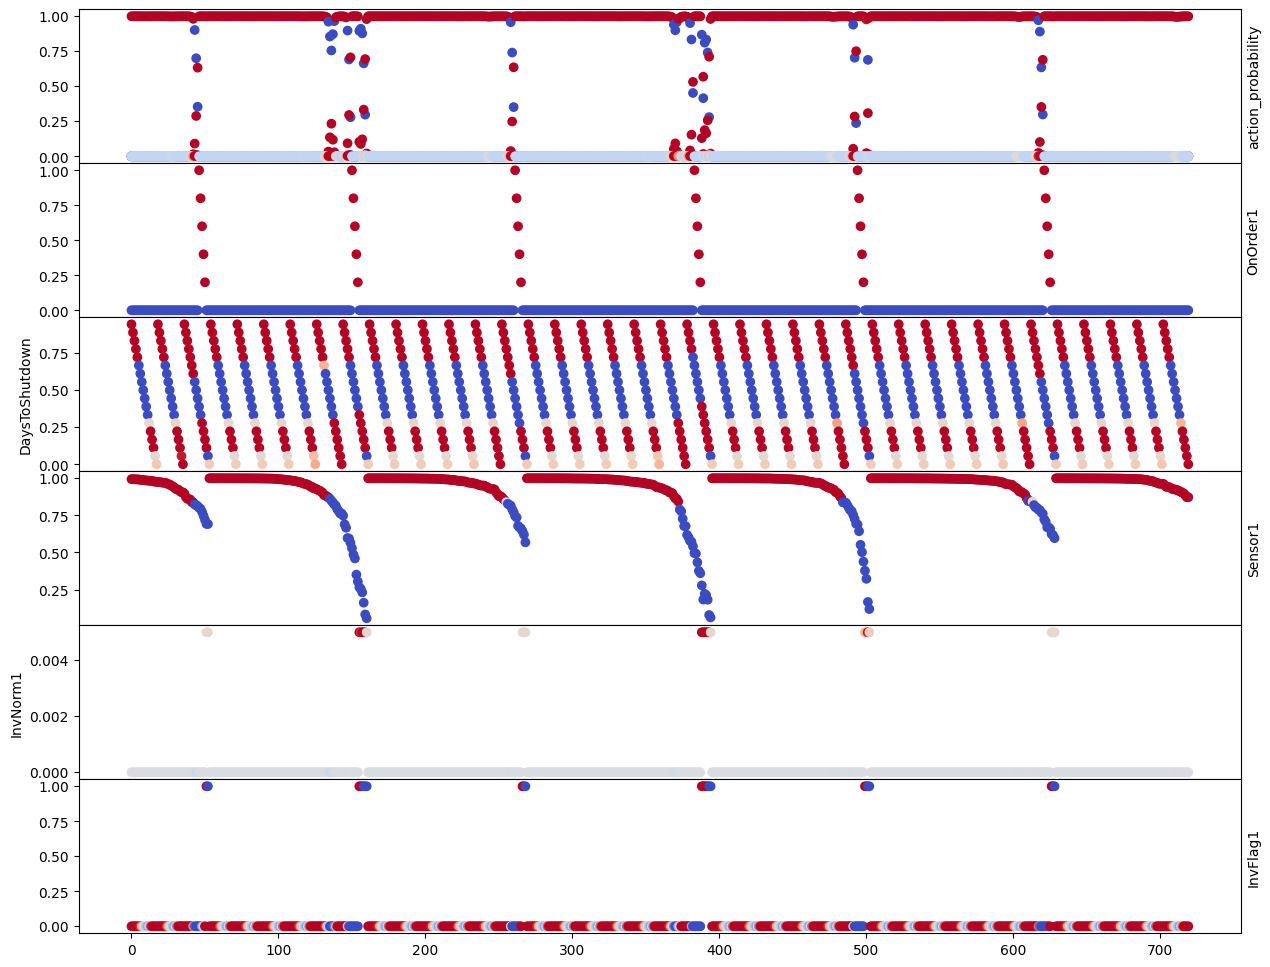

In [34]:
# output with shap values
explain(state_log_reshaped, feature_names, model_predict(state_log_reshaped))

In [35]:
action_log_[:,0].shape

(720,)

In [37]:
def explain(state_log_=state_log_reshaped, feature_names=feature_names, action_prob=model_predict(state_log_reshaped), cmap='coolwarm', save_fig=False):


    state_log_reshaped_min = state_log_reshaped.min()
    state_log_reshaped_max = state_log_reshaped.max()

    state_log_re = state_log_*(state_log_reshaped_max - state_log_reshaped_min) + state_log_reshaped_min # rescale state log

    actions = action_log_
    state_log_re = state_log_*(state_log_reshaped_max - state_log_reshaped_min) + state_log_reshaped_min # rescale state log

    norm = plt.Normalize(vmin=-0.001, vmax=0.001) # define color scala between 0 and +2 (like the agents action space)

    fig = plt.figure(figsize=(15,12))
    gs = fig.add_gridspec(7, hspace=0)
    axs = gs.subplots(sharex=True, sharey=False)
    axs[0].scatter(range(0, action_prob.shape[0]), action_prob[:,0], c=action_prob[:,0]- explainer.expected_value[0], cmap = cmap, norm=norm)
    axs[0].set_ylabel('action_probability')
    axs[0].yaxis.set_label_position('right')
    axs[0].scatter(range(0, action_prob.shape[0]), action_prob[:,1], c=action_prob[:,1]- explainer.expected_value[1], cmap = cmap, norm=norm)
    axs[0].set_ylabel('action_probability')
    axs[0].yaxis.set_label_position('right')
    axs[0].scatter(range(0, action_prob.shape[0]), action_prob[:,2], c=action_prob[:,2]- explainer.expected_value[2], cmap = cmap, norm=norm)
    axs[0].set_ylabel('action_probability')
    axs[0].yaxis.set_label_position('right')
    axs[0].scatter(range(0, action_prob.shape[0]), action_prob[:,3], c=action_prob[:,3]- explainer.expected_value[3], cmap = cmap, norm=norm)
    axs[0].set_ylabel('action_probability')
    axs[0].yaxis.set_label_position('right')
    axs[0].scatter(range(0, action_prob.shape[0]), action_prob[:,4], c=action_prob[:,4]- explainer.expected_value[4], cmap = cmap, norm=norm)
    axs[0].set_ylabel('action_probability')
    axs[0].yaxis.set_label_position('right')
    axs[0].scatter(range(0, action_prob.shape[0]), action_prob[:,5], c=action_prob[:,5]- explainer.expected_value[5], cmap = cmap, norm=norm)
    axs[0].set_ylabel('action_probability')
    axs[0].yaxis.set_label_position('right')

    axs[1].scatter(range(0, actions.shape[0]), actions[:,0], c=actions[:,0]- explainer.expected_value[0], cmap = cmap, norm=norm)
    axs[1].scatter(range(0, actions.shape[0]), actions[:,1], c=actions[:,1]- explainer.expected_value[1], cmap = cmap, norm=norm)
    axs[1].set_ylabel('selected_actions')
    axs[1].yaxis.set_label_position('right')

    axs[2].scatter(range(0,len(shap_values[0][:,4])), state_log_re[:,4], c=shap_values[0][:,4], cmap=cmap, norm=norm)
    axs[2].set_ylabel(feature_names[4])

    axs[3].scatter(range(0,len(shap_values[0][:,0])), state_log_re[:,0], c=shap_values[0][:,0], cmap=cmap, norm=norm)
    axs[3].set_ylabel(feature_names[0])
    axs[3].yaxis.set_label_position('right')

    axs[4].scatter(range(0,len(shap_values[0][:,1])), state_log_re[:,1], c=shap_values[0][:,1], cmap=cmap, norm=norm)
    axs[4].set_ylabel(feature_names[1])

    axs[5].scatter(range(0,len(shap_values[0][:,2])), state_log_re[:,2], c=shap_values[0][:,2], cmap=cmap, norm=norm)
    axs[5].set_ylabel(feature_names[2])
    axs[5].yaxis.set_label_position('right')

    axs[6].scatter(range(0,len(shap_values[0][:,3])), state_log_re[:,3], c=shap_values[0][:,3], cmap=cmap, norm=norm)
    axs[6].set_ylabel(feature_names[3])



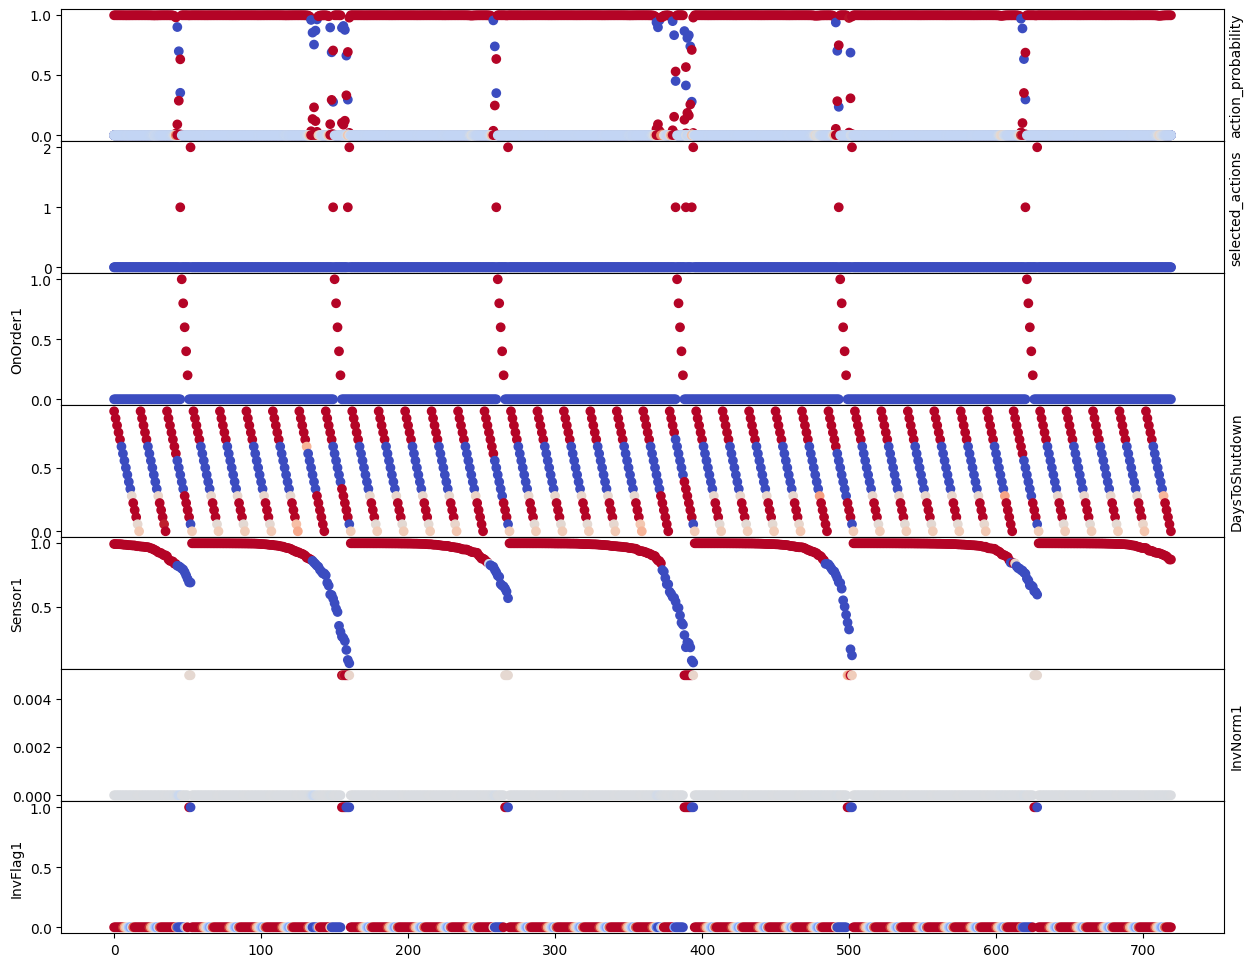

In [38]:
# output with shap values
explain(state_log_reshaped, feature_names, model_predict(state_log_reshaped))

# MATLAB's Results

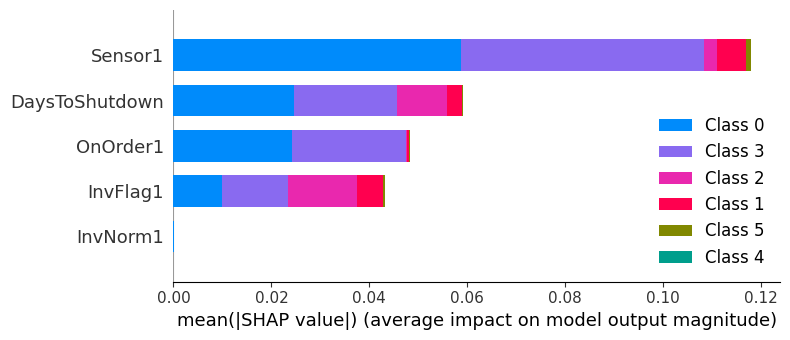

In [39]:
shap.summary_plot(shap_values, feature_names=feature_names)

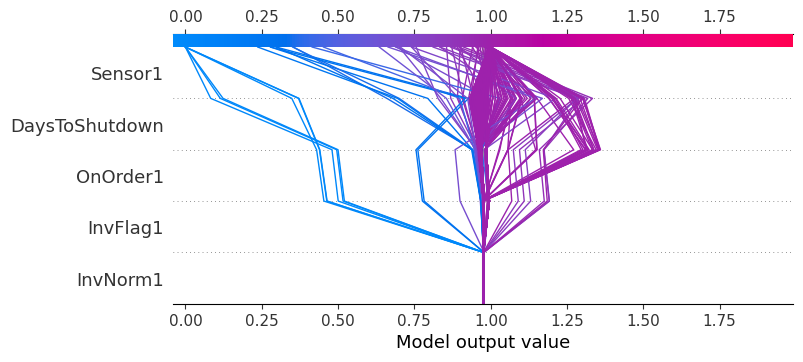

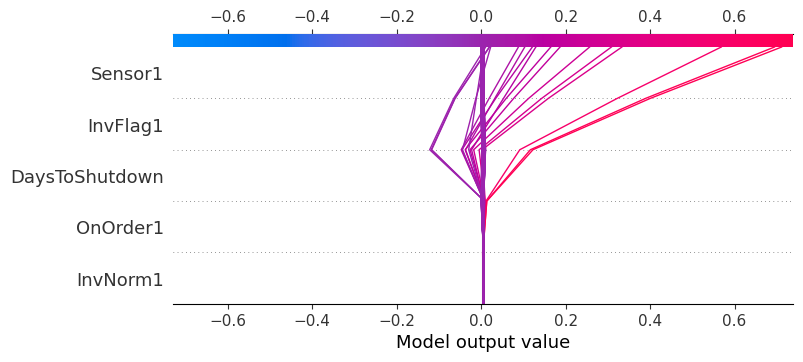

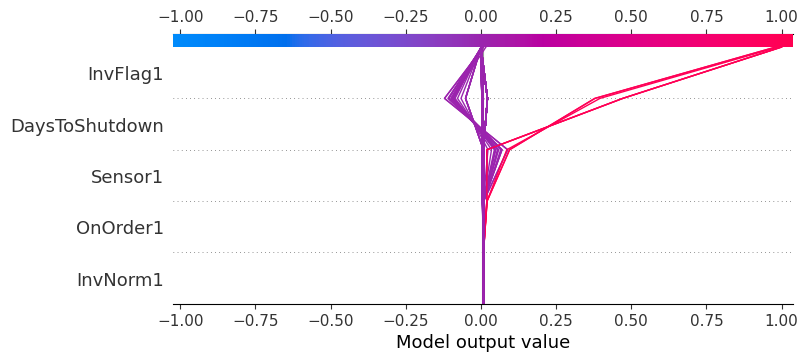

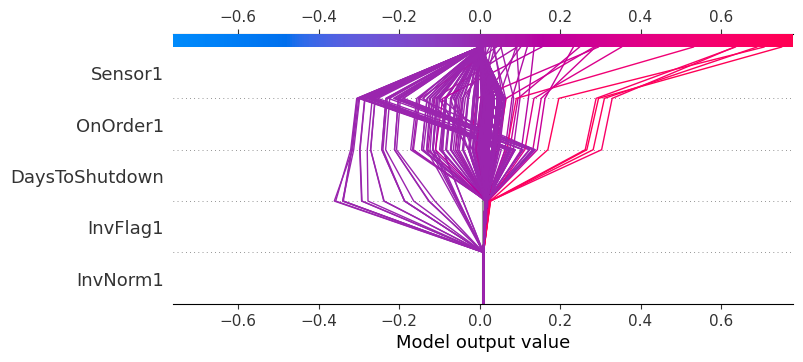

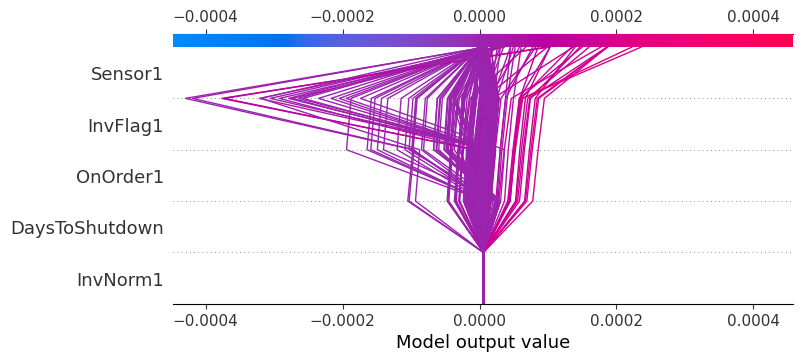

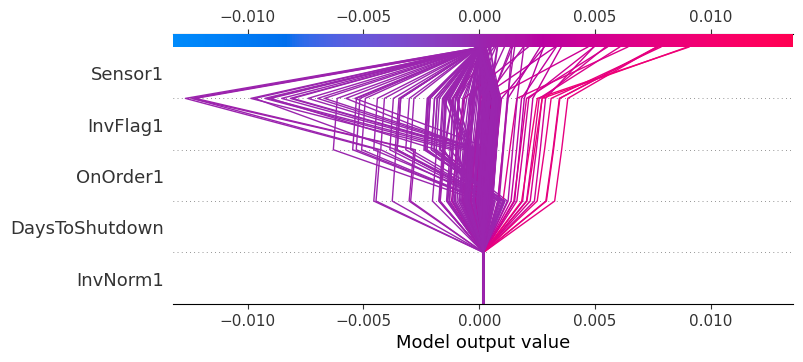

In [40]:
for i in range(len(shap_values)):
  shap.decision_plot(explainer.expected_value[i], shap_values[i], feature_names=feature_names)


In [41]:
shap.initjs()
shap.force_plot(explainer.expected_value[1], shap_values[1][0], feature_names=feature_names,
                link='logit', matplotlib=False)

In [42]:
shap.initjs()
shap.force_plot(explainer.expected_value[2], shap_values[2][0], feature_names=feature_names,
                link='logit', matplotlib=False)

In [43]:
shap.initjs()
shap.force_plot(explainer.expected_value[3], shap_values[3][0], feature_names=feature_names,
                link='logit', matplotlib=False)

In [44]:
shap.initjs()
shap.force_plot(explainer.expected_value[4], shap_values[3][0], feature_names=feature_names,
                link='logit', matplotlib=False)

In [45]:
shap_values_ = np.array(shap_values)
print(shap_values_.shape)
shap_values_ = np.array(shap_values[1])
print(shap_values_.shape)


(6, 720, 5)
(720, 5)


In [46]:
shap.initjs()
shap.force_plot(explainer.expected_value[0], shap_values[0], feature_names=feature_names,
                link='logit', matplotlib=False)

In [47]:
explainer_critic = shap.KernelExplainer(model_criticNet, state_log_)
shap_values_critic = explainer.shap_values(state_log_) # Calculate shap values

  0%|          | 0/720 [00:00<?, ?it/s]

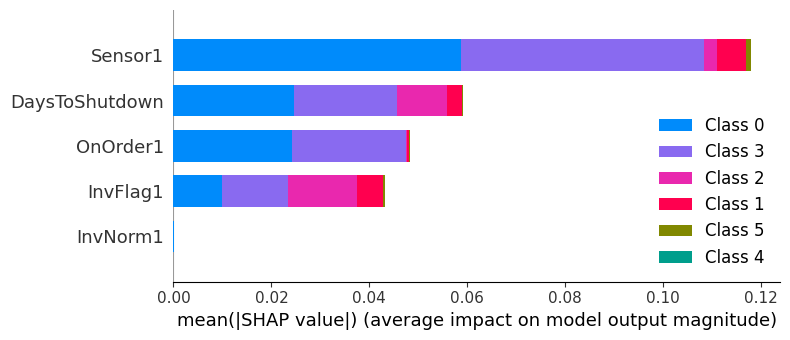

In [48]:
shap.summary_plot(shap_values_critic, feature_names=feature_names)

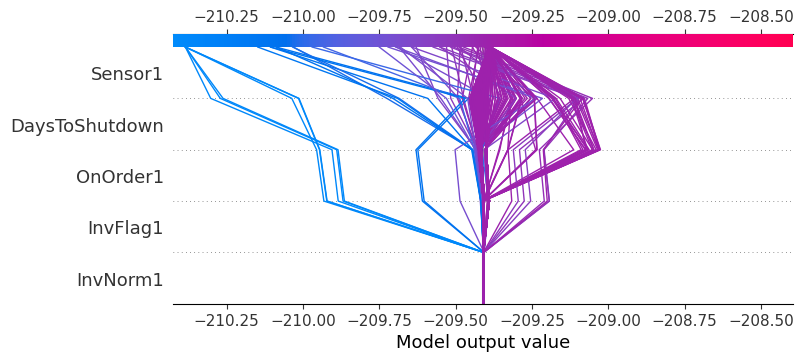

In [49]:
shap.decision_plot(explainer_critic.expected_value[0], shap_values_critic[0], feature_names=feature_names)


